In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from scipy import stats
import operator

import sys 
sys.path.append(r'..\utils') 
from utils import get_seaad_colors, get_tx_order

In [2]:
#HANN mapping
class_col =     'HANN_class_label_assignment_winner'
subclass_col =  'HANN_subclass_label_assignment_winner'
cluster_col =   'HANN_cluster_label_assignment_winner'

In [3]:
#load data

data_root = r'\\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\datasets\human_exc\data\Features\dendrite'
output_dir = r'\\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\datasets\human_exc\analysis\20250204_seaad\dendrite'
layer_aligned_dir = r'\\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\datasets\human_exc\data\SWC_LayerAligned' #path to folder with layer aligned swcs for these cells 

os.makedirs(output_dir, exist_ok=True)

metadata = pd.read_csv(os.path.join(data_root, 'metadata.csv'))
aligned_histogram = pd.read_csv(os.path.join(data_root, 'AlignedHistogram.csv'))
aligned_soma_depths = pd.read_csv(os.path.join(data_root, 'AlignedSomaDepths.csv'))
raw_feature_wide = pd.read_csv(os.path.join(data_root, 'RawFeatureWide.csv'))

In [4]:
#get seaad colors 
color_dict = get_seaad_colors()

In [5]:
#data wrangling

#combine data and get la file paths 
metadata = metadata.rename(columns={"cell_id": "specimen_id", cluster_col: "t_type", subclass_col:'subclass_label'})#, "Pinned Structure and Layer": "final_structure"})
metadata = metadata[['specimen_id', 't_type', 'subclass_label', 'seuratQCpass']]

#remove vals without a seaad mapping
metadata['t_type'] = metadata['t_type'].fillna('TBD')
metadata['subclass_label'] = metadata['subclass_label'].fillna('TBD')

#add soma depths and features
data = metadata.merge(aligned_soma_depths, how='inner', on='specimen_id')
data = data.merge(raw_feature_wide, how='inner', on='specimen_id') 

#sort the cells
sorted_data = data.sort_values(by=['t_type', 'soma_distance_from_pia'])

#delete columns where any vals are nan
sorted_clean_data = sorted_data.dropna(axis=1, how='all')


In [6]:
#Get custom transcriptomic order
ttype_order, subclass_order = get_tx_order(sorted_clean_data, 't_type')
group_order = {
    'subclass_label' : subclass_order,
    't_type' :  ttype_order
}

Eta^2 of subclasses

In [7]:
# subclass x feature H vals
x_var = 'subclass_label' #what to do box plots on 
features = raw_feature_wide.columns.tolist()[1:]

x_var_order = group_order[x_var]


# Kruscal-Wallis H test on all features
kw_hvals_subclass = dict()

for f in features:
    # Create a list of groups dynamically
    groups = [sorted_clean_data.loc[sorted_clean_data[x_var] == x][f].dropna() for x in x_var_order]
    
    # Only include groups that have data
    groups = [group for group in groups if not group.empty]

    if len(groups) < 2:
        print(f"Not enough groups with data for feature {f}")
        continue

    try:
        hvalue, pvalue = stats.kruskal(*groups, nan_policy='omit')
        kw_hvals_subclass[f] = hvalue
    except ValueError as e:
        print(f'Kruskal-Wallis not calculated for {f} because of an error: {e}')


#eta-squared from one-way ANOVA
#eta^2 = % of variance in DV (subclass) explained by IV (feature)
eta_squared_subclass = {}
k = len(x_var_order) #number of groups
n = len(sorted_clean_data.loc[sorted_clean_data[x_var].isin(x_var_order)]) #total number of observations 
for f,h in kw_hvals_subclass.items():
    # eta2[H] = (H - k + 1)/(n - k) #k = number of groups; n = total number of observations; h=the value obtained in the KW test (the h-test statistic)
    esq = (h - k + 1)/(n - k)
    eta_squared_subclass[f] = esq

eta_squared_subclass_df = pd.DataFrame.from_dict(sorted(eta_squared_subclass.items(),key=operator.itemgetter(1), reverse=True))
eta_squared_subclass_df.rename(columns = {0:'feature', 1:'eta_squared'}, inplace = True)

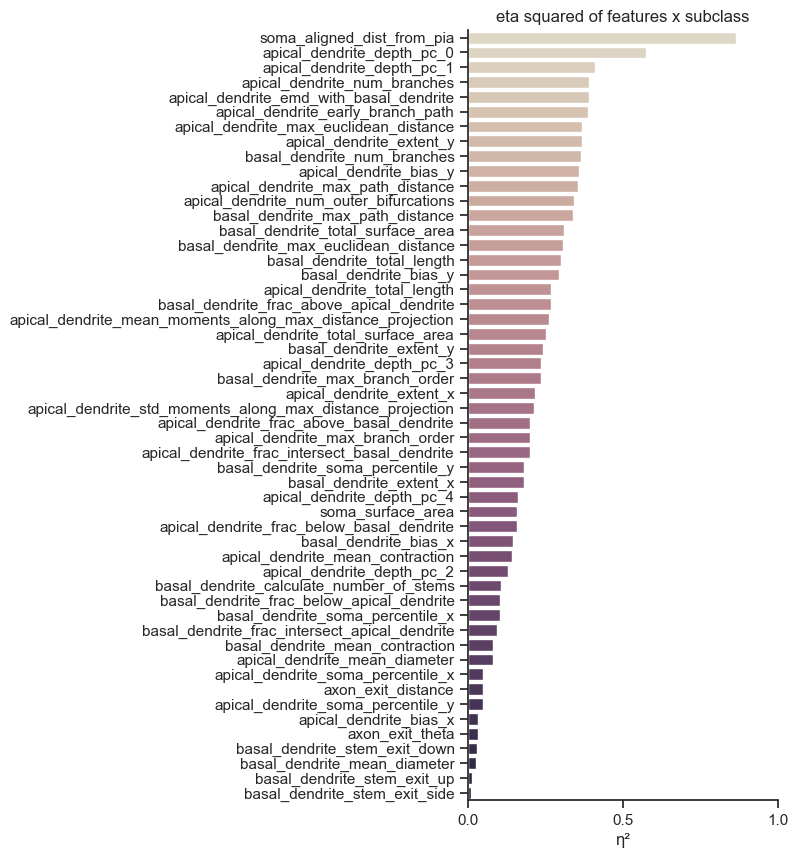

<Figure size 640x480 with 0 Axes>

In [8]:
# eta squared of features on subclasses 
#how much of the variance between subclasses is explained by each feature? 
#a way of getting at which features most 'separate' subclasses. 

fig_name = 'eta_squared_features_x_subclass.pdf'
fig_path = os.path.join(output_dir, fig_name)

#color palette
values = sns.color_palette("ch:s=-.2,r=.6", len(eta_squared_subclass_df)) # 10 colors
keys = eta_squared_subclass_df.feature
color_palette = dict(zip(keys, values))


#plot!
sns.set_theme(style="white")
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
with PdfPages(fig_path) as pdf:

    fig, ax = plt.subplots(figsize=(4, 10))

    #plot pvals 
    sns.barplot(x="eta_squared", y='feature', data=eta_squared_subclass_df, palette=color_palette)
    sns.despine()

    #edit axis labels 
    ax.set(xlabel="\u03B7\u00b2", ylabel="")
    plt.xticks(ticks=[0,0.5,1])

    # #plot significance threshold for pvals
    # plt.axvline(x = signif_thresh, color=(1, 0, 0, 0.6), linewidth=2)

    #add title
    plt.title('eta squared of features x subclass')

    # save the current figure
    pdf.savefig(fig, bbox_inches='tight')
    plt.show() #show the fig
    plt.clf() #destoy current fig to save memory


Eta^2 of ttypes within each subclass

In [9]:
#ttypes within each subclass

features = raw_feature_wide.columns.tolist()[1:]
ttype_order = group_order['t_type']

# subclass x feature stats
subcalss_var = 'subclass_label' #what to do box plots on 
subclass_var_order = group_order[subcalss_var]

eta_squared_subclass = dict()
for subclass in subclass_var_order:
    print(subclass)
    subclass_data = sorted_clean_data.loc[sorted_clean_data[subcalss_var] == subclass]

    #now run stats on the ttypes in this subclass 
    x_var = 't_type'  # what to do box plots on
    x_var_order = [t for t in ttype_order if t in subclass_data[x_var].unique()]

   # Kruscal-Wallis H test on all features
    kw_hvals_ttypes = dict()
    kw_pvals_ttypes = dict()
    for f in features:
        # Create a list of groups dynamically
        groups = [subclass_data.loc[subclass_data[x_var] == x][f].dropna() for x in x_var_order]


        min_cells_per_ttype = 1
        groups = [group for group in groups if len(group) >= min_cells_per_ttype]
        
        # Only include groups that have data
        groups = [group for group in groups if not group.empty]

        if len(groups) < 2:
            print(f"Not enough groups with data for feature {f}")
            continue

        try:
            hvalue, pvalue = stats.kruskal(*groups, nan_policy='omit')
            kw_hvals_ttypes[f] = hvalue
            kw_pvals_ttypes[f] = pvalue
        except ValueError as e:
            print(f'Kruskal-Wallis not calculated for {f} because of an error: {e}')


    #eta-squared from one-way ANOVA
    #eta^2 = % of variance in DV (subclass) explained by IV (feature)
    eta_squared_ttypes = {}
    # k = len(x_var_order) #number of groups
    k = len(groups)
    n = sum([len(group) for group in groups])
    # n = len(subclass_data.loc[subclass_data[x_var].isin(x_var_order)]) #total number of observations 
    print('k: {}'.format(k))
    print('n: {}'.format(n))
    for f,h in kw_hvals_ttypes.items():
        # eta2[H] = (H - k + 1)/(n - k) #k = number of groups; n = total number of observations; h=the value obtained in the KW test (the h-test statistic)
        esq = (h - k + 1)/(n - k)
        eta_squared_ttypes[f] = esq

    eta_squared_ttypes_df = pd.DataFrame.from_dict(sorted(eta_squared_ttypes.items(),key=operator.itemgetter(1), reverse=True))
    eta_squared_ttypes_df.rename(columns = {0:'feature', 1:'eta_squared'}, inplace = True)


    eta_squared_subclass[subclass] = eta_squared_ttypes_df


L2/3 IT
Kruskal-Wallis not calculated for apical_dendrite_frac_below_basal_dendrite because of an error: All numbers are identical in kruskal
Kruskal-Wallis not calculated for basal_dendrite_frac_above_apical_dendrite because of an error: All numbers are identical in kruskal
k: 9
n: 120
L4 IT
Kruskal-Wallis not calculated for basal_dendrite_frac_above_apical_dendrite because of an error: All numbers are identical in kruskal
k: 4
n: 68
L5 ET
Kruskal-Wallis not calculated for basal_dendrite_frac_above_apical_dendrite because of an error: All numbers are identical in kruskal
Kruskal-Wallis not calculated for basal_dendrite_stem_exit_down because of an error: All numbers are identical in kruskal
k: 3
n: 8
L5 IT
Kruskal-Wallis not calculated for apical_dendrite_frac_below_basal_dendrite because of an error: All numbers are identical in kruskal
Kruskal-Wallis not calculated for basal_dendrite_frac_above_apical_dendrite because of an error: All numbers are identical in kruskal
k: 6
n: 46
L5/6

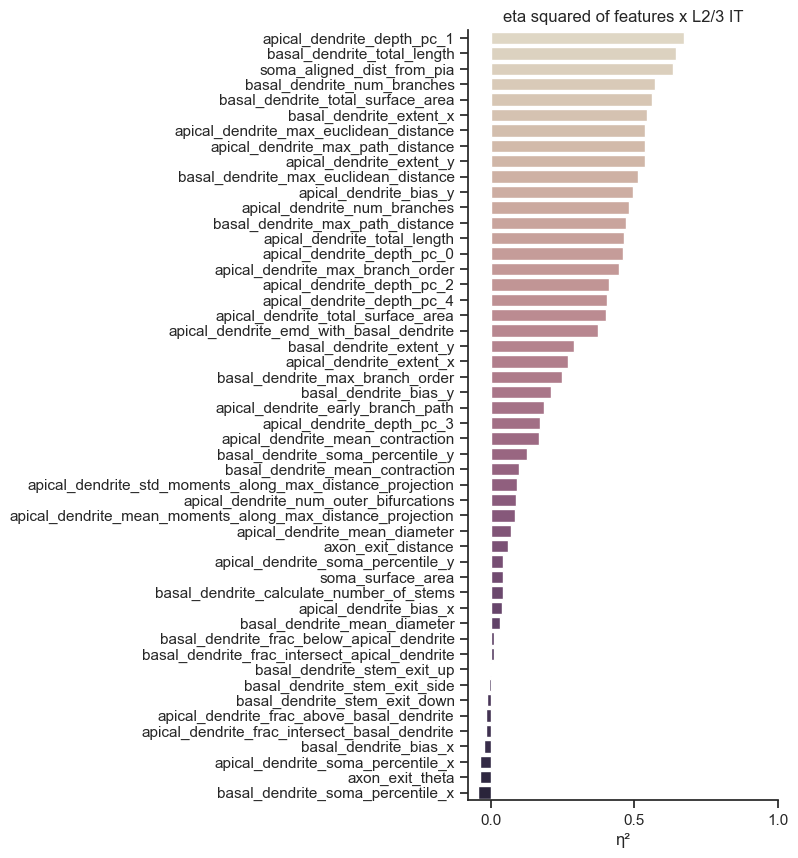

<Figure size 640x480 with 0 Axes>

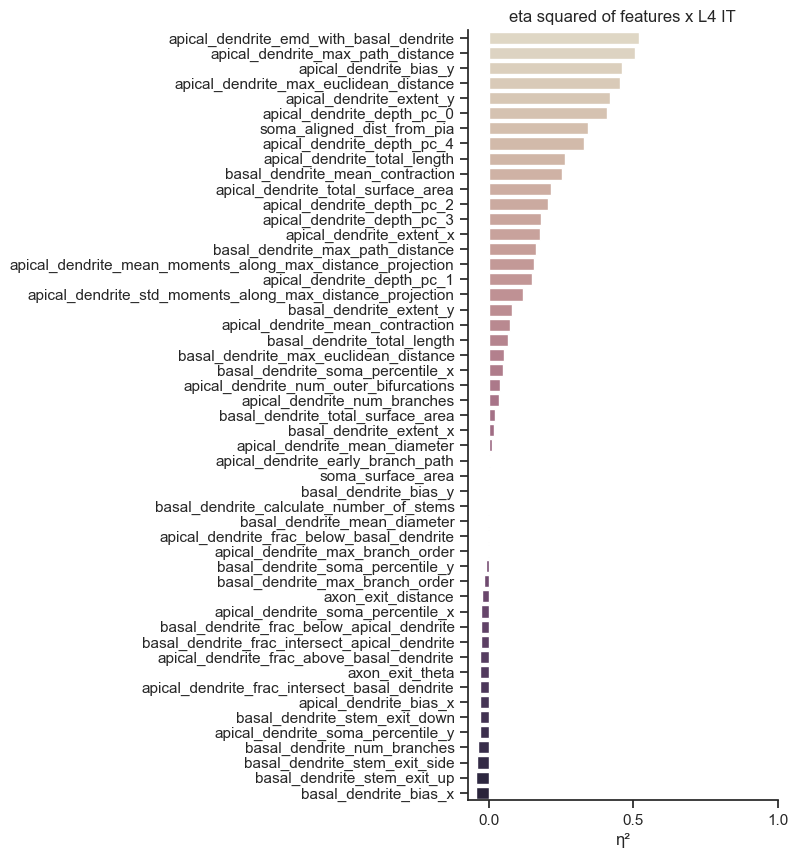

<Figure size 640x480 with 0 Axes>

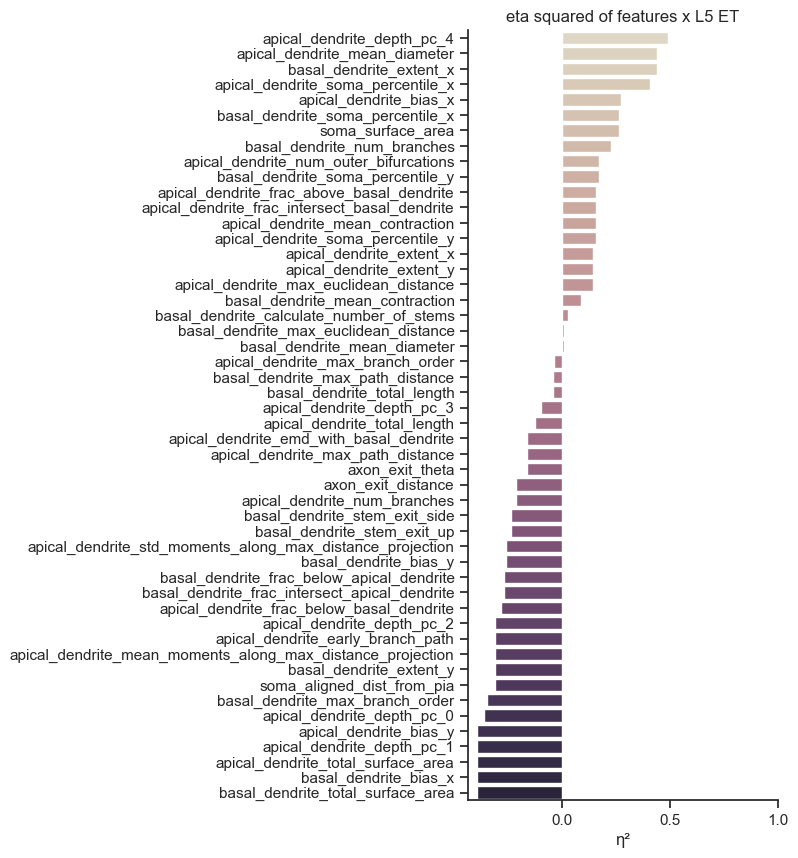

<Figure size 640x480 with 0 Axes>

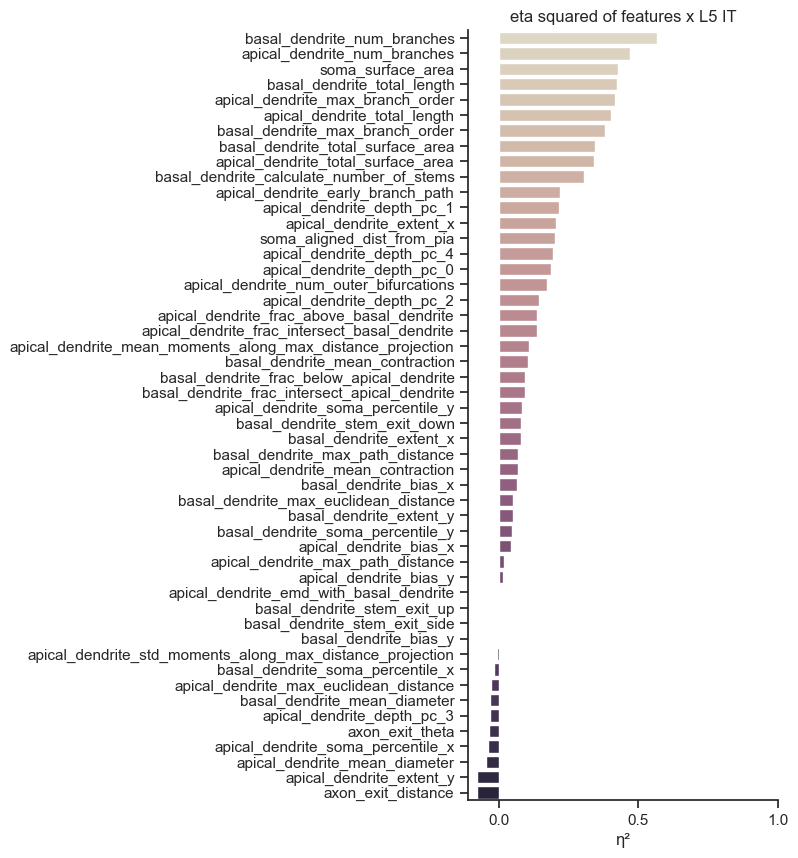

<Figure size 640x480 with 0 Axes>

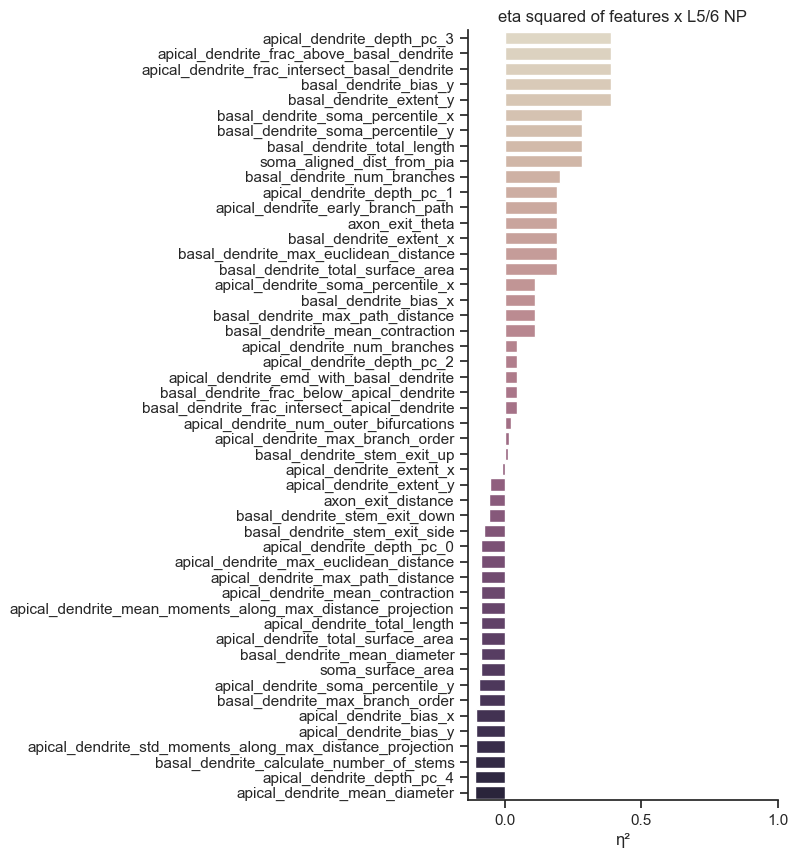

<Figure size 640x480 with 0 Axes>

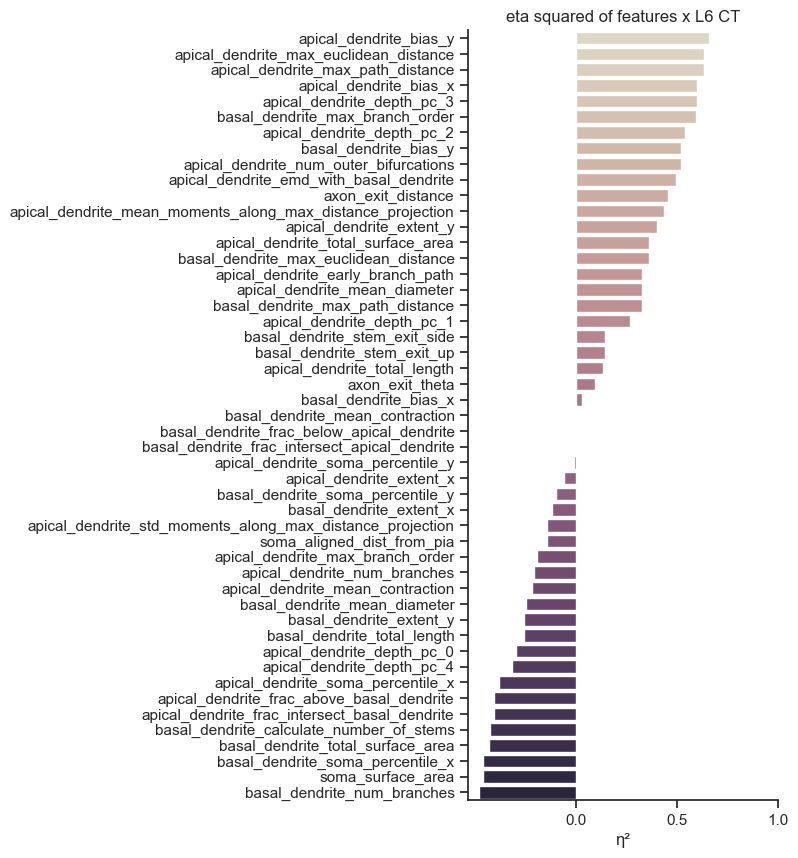

<Figure size 640x480 with 0 Axes>

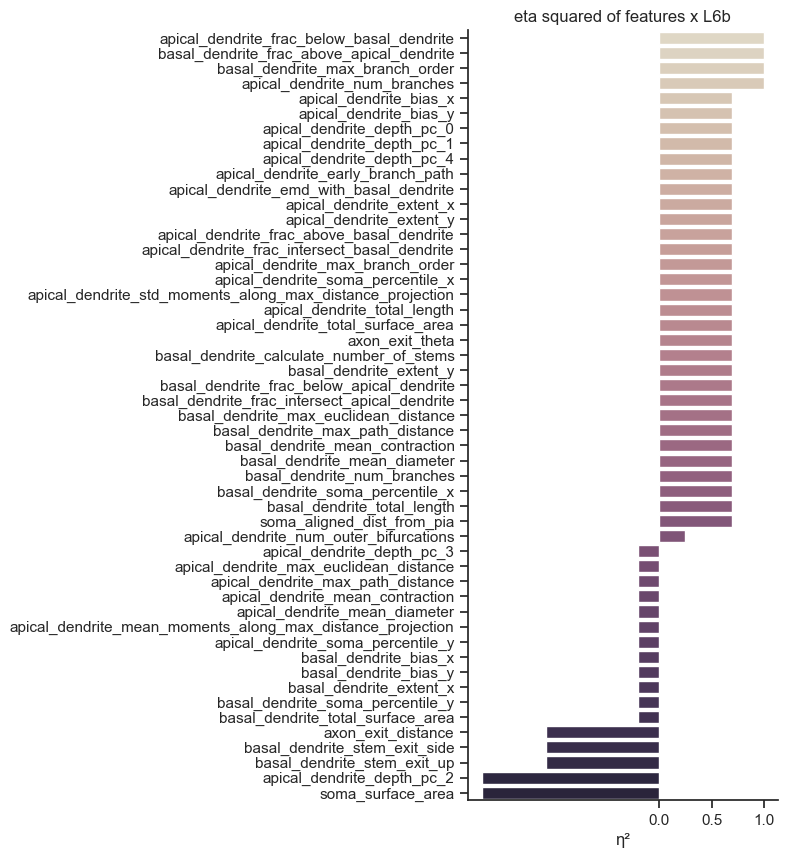

<Figure size 640x480 with 0 Axes>

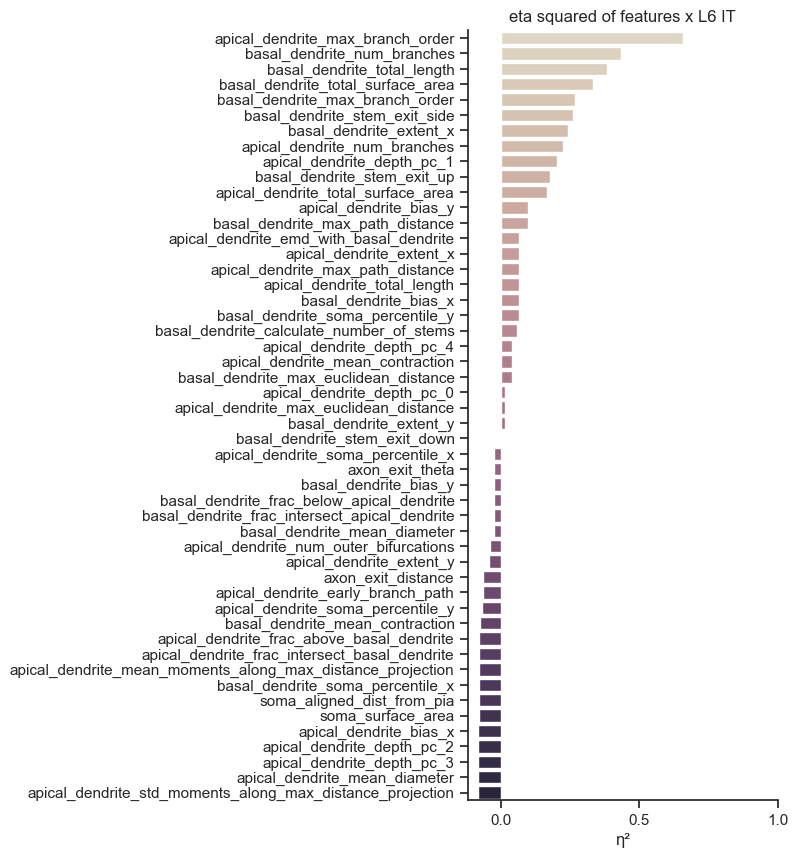

<Figure size 640x480 with 0 Axes>

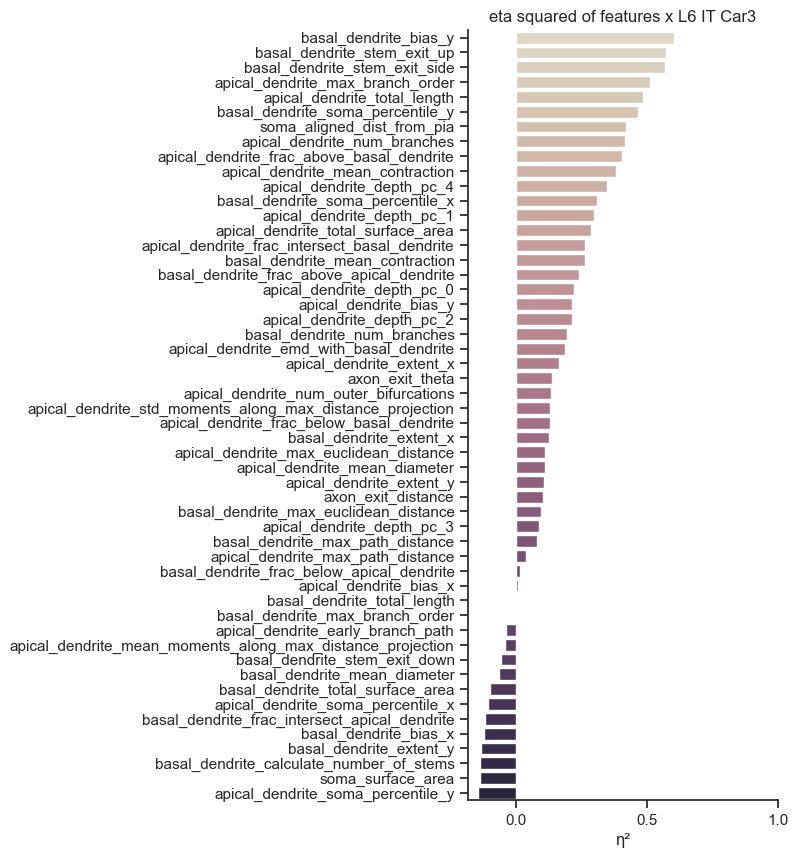

<Figure size 640x480 with 0 Axes>

In [10]:
# eta squared of features on subclasses 
#how much of the variance between subclasses is explained by each feature? 
#a way of getting at which features most 'separate' subclasses. 


for subclass in eta_squared_subclass.keys():
    if not eta_squared_subclass[subclass].empty:
        #has eta2 data to show
        eta_squared_ttypes_df = eta_squared_subclass[subclass]

        fig_name = 'eta_squared_features_x_{}_ttypes.pdf'.format(subclass.replace('/', '-').replace(' ', '_'))
        fig_path = os.path.join(output_dir, fig_name)

        #color palette
        values = sns.color_palette("ch:s=-.2,r=.6", len(eta_squared_ttypes_df)) # 10 colors
        keys = eta_squared_ttypes_df.feature
        color_palette = dict(zip(keys, values))


        #plot!
        sns.set_theme(style="white")
        plt.rcParams['xtick.bottom'] = True
        plt.rcParams['ytick.left'] = True
        with PdfPages(fig_path) as pdf:

            fig, ax = plt.subplots(figsize=(4, 10))

            #plot pvals 
            sns.barplot(x="eta_squared", y='feature', data=eta_squared_ttypes_df, palette=color_palette)
            sns.despine()

            #edit axis labels 
            ax.set(xlabel="\u03B7\u00b2", ylabel="")
            plt.xticks(ticks=[0,0.5,1])

            # #plot significance threshold for pvals
            # plt.axvline(x = signif_thresh, color=(1, 0, 0, 0.6), linewidth=2)

            #add title
            plt.title('eta squared of features x {}'.format(subclass))

            # save the current figure
            pdf.savefig(fig, bbox_inches='tight')
            plt.show() #show the fig
            plt.clf() #destoy current fig to save memory


Eta^2 of all ttypes

In [11]:
# subclass x feature H vals
x_var = 't_type' #what to do box plots on 
features = raw_feature_wide.columns.tolist()[1:]

x_var_order = group_order[x_var]


# Kruscal-Wallis H test on all features
kw_hvals_subclass = dict()

for f in features:
    # Create a list of groups dynamically
    groups = [sorted_clean_data.loc[sorted_clean_data[x_var] == x][f].dropna() for x in x_var_order]
    
    # Only include groups that have data
    groups = [group for group in groups if not group.empty]

    if len(groups) < 2:
        print(f"Not enough groups with data for feature {f}")
        continue

    try:
        hvalue, pvalue = stats.kruskal(*groups, nan_policy='omit')
        kw_hvals_subclass[f] = hvalue
    except ValueError as e:
        print(f'Kruskal-Wallis not calculated for {f} because of an error: {e}')


#eta-squared from one-way ANOVA
#eta^2 = % of variance in DV (subclass) explained by IV (feature)
eta_squared_subclass = {}
k = len(x_var_order) #number of groups
n = len(sorted_clean_data.loc[sorted_clean_data[x_var].isin(x_var_order)]) #total number of observations 
for f,h in kw_hvals_subclass.items():
    # eta2[H] = (H - k + 1)/(n - k) #k = number of groups; n = total number of observations; h=the value obtained in the KW test (the h-test statistic)
    esq = (h - k + 1)/(n - k)
    eta_squared_subclass[f] = esq

eta_squared_subclass_df = pd.DataFrame.from_dict(sorted(eta_squared_subclass.items(),key=operator.itemgetter(1), reverse=True))
eta_squared_subclass_df.rename(columns = {0:'feature', 1:'eta_squared'}, inplace = True)

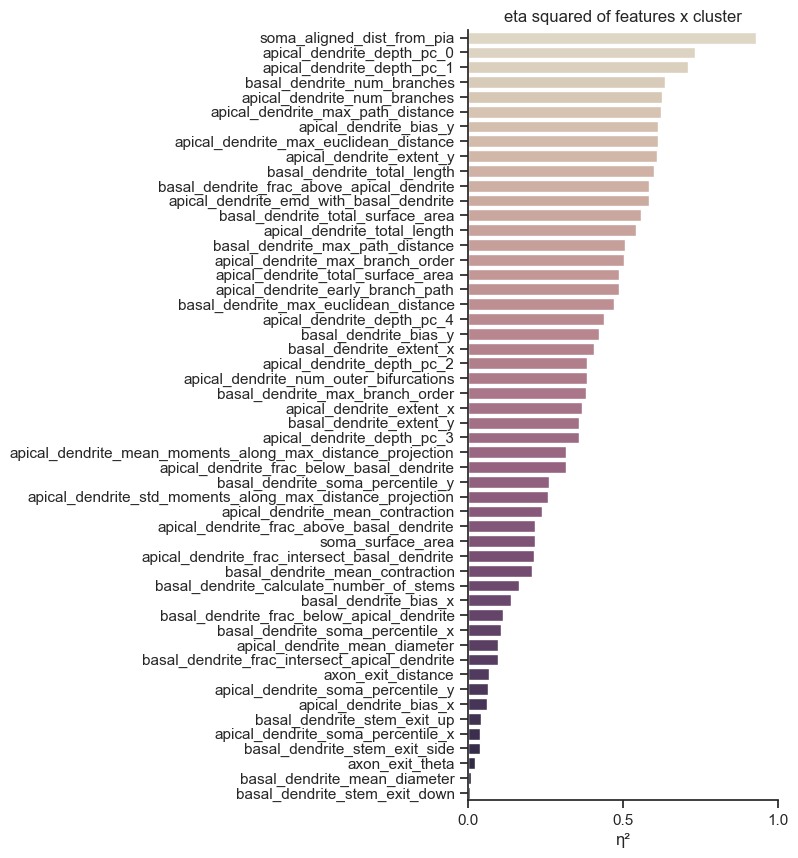

<Figure size 640x480 with 0 Axes>

In [12]:
# eta squared of features on subclasses 
#how much of the variance between subclasses is explained by each feature? 
#a way of getting at which features most 'separate' subclasses. 

fig_name = 'eta_squared_features_x_cluster.pdf'
fig_path = os.path.join(output_dir, fig_name)

#color palette
values = sns.color_palette("ch:s=-.2,r=.6", len(eta_squared_subclass_df)) # 10 colors
keys = eta_squared_subclass_df.feature
color_palette = dict(zip(keys, values))


#plot!
sns.set_theme(style="white")
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
with PdfPages(fig_path) as pdf:

    fig, ax = plt.subplots(figsize=(4, 10))

    #plot pvals 
    sns.barplot(x="eta_squared", y='feature', data=eta_squared_subclass_df, palette=color_palette)
    sns.despine()

    #edit axis labels 
    ax.set(xlabel="\u03B7\u00b2", ylabel="")
    plt.xticks(ticks=[0,0.5,1])

    # #plot significance threshold for pvals
    # plt.axvline(x = signif_thresh, color=(1, 0, 0, 0.6), linewidth=2)

    #add title
    plt.title('eta squared of features x cluster')

    # save the current figure
    pdf.savefig(fig, bbox_inches='tight')
    plt.show() #show the fig
    plt.clf() #destoy current fig to save memory
